In [1]:
import pandas as pd
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np


In [2]:
import surp
from surp import gce_math as gcem
import arya

from surp import subgiants

In [3]:
data_dir = surp._globals.DATA_DIR

# Cleaning GALAH

see https://www.galah-survey.org/dr3/using_the_data/.

In [4]:
galah_all = Table.read(f"{data_dir}/GALAH_DR3_main_allstar_v2.fits", format="fits", memmap=True)

In [ ]:
mask = galah_all["flag_sp"] == 0
mask &= galah_all["flag_fe_h"] == 0
mask &= galah_all["snr_c3_iraf"] > 30


abund_mask = ~np.isnan(galah_all["C_fe"])
abund_mask &= ~np.isnan(galah_all["Mg_fe"])
abund_mask &= ~np.isnan(galah_all["fe_h"])
abund_mask &= galah_all["flag_C_fe"] == 0
abund_mask &= (galah_all["flag_O_fe"] == 0) | (galah_all["flag_Mg_fe"] == 0)


df = galah_all[mask].to_pandas()

df["MG_H"] = df["Mg_fe"] + df["fe_h"]
df["C_MG"] = df["C_fe"] - df["Mg_fe"] 
df["C_O"] = df["C_fe"] - df["O_fe"] 

df["O_H"] = df["O_fe"] + df["fe_h"]
df["MG_O"] = df["O_fe"] - df["Mg_fe"]

df["FE_H"] = df["fe_h"]
df["MG_FE"] = df["Mg_fe"]


df["LOGG"] = df["logg"]
df["TEFF"] = df["teff"]

galah = df

In [ ]:
coords = [
    (3.5, 4800),
    (3.8, 4875),
    (4.1, 5300),
    (3.8, 5500),
    (3.5, 5250),
    (3.5, 4800)
]
y = [c[0] for c in coords]
x = [c[1] for c in coords]

In [ ]:
plt.hist2d(galah["TEFF"], galah["LOGG"], 200, 
           range=[[3000, 8000], [0.5, 5]], norm=mpl.colors.LogNorm())
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.plot(x, y)

In [ ]:
logg = galah["logg"]
teff = galah["teff"]



mask = ~np.isnan(logg)
mask &= ~np.isnan(teff)

mask &= logg >= 3.5
# mask &= logg <= 0.004*teff - 15.7
# mask &= logg <= 0.000706*teff + 0.36
# mask &= logg <= -0.0015 * teff + 12.05
# mask &= logg >= 0.0012*teff - 2.8

mask &= galah["e_logg"] < 0.5
mask &= galah["e_teff"] < 200

df = galah.loc[mask]

In [ ]:
plt.hist(galah["e_logg"], 50, range=(0.1, 1), log=True);

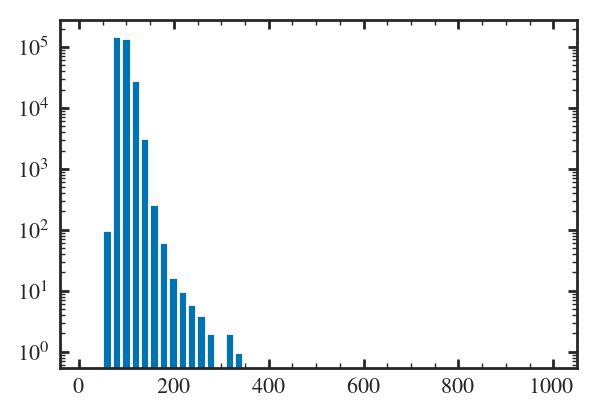

In [14]:
plt.hist(galah["e_teff"], 50, range=(10, 1000), log=True);

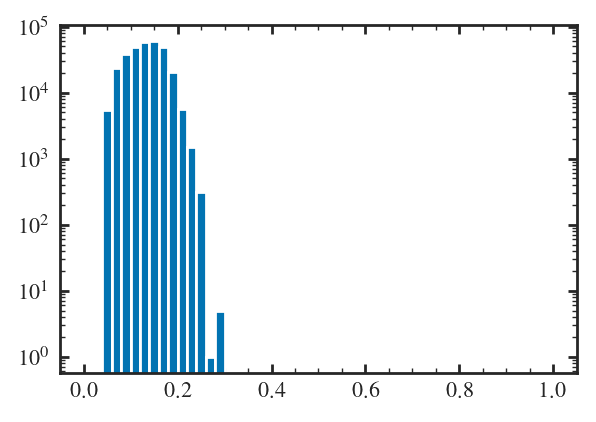

In [15]:
plt.hist(galah["e_O_fe"], 50, range=(0, 1), log=True);

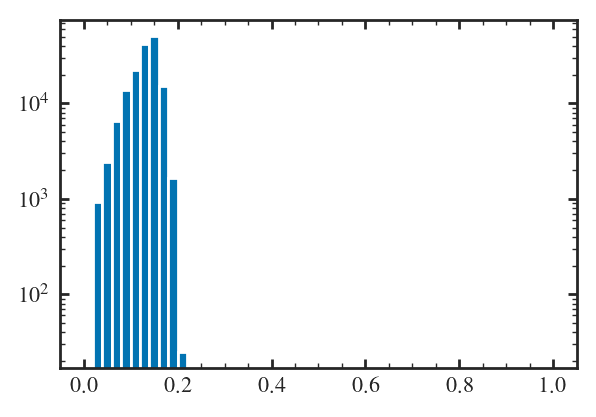

In [16]:
plt.hist(galah["e_C_fe"], 50, range=(0, 1), log=True);

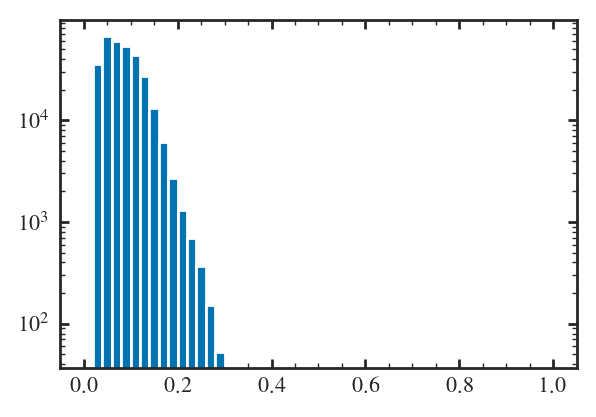

In [17]:
plt.hist(galah["e_Mg_fe"], 50, range=(0, 1), log=True);

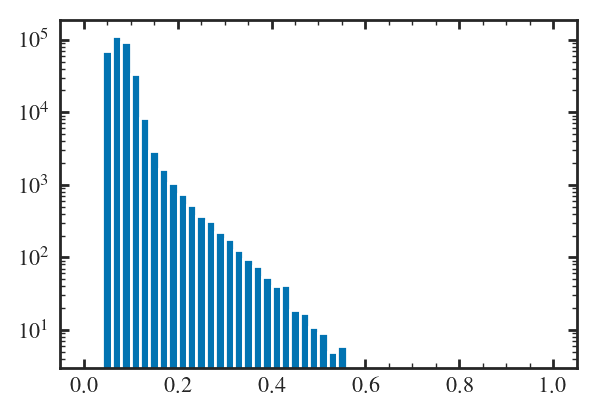

In [18]:
plt.hist(galah["e_fe_h"], 50, range=(0, 1), log=True);

In [19]:
def plot_ab(df, x, y):
    plt.hist2d(df[x], df[y], 100, range=[[-1, 1], [-1, 1]], norm=mpl.colors.LogNorm())
    arya.plotting.medianplot(df, x, y, numbins=25, color="k")
    plt.xlabel(x.replace("_", "/"))
    plt.ylabel(y.replace("_", "/"))

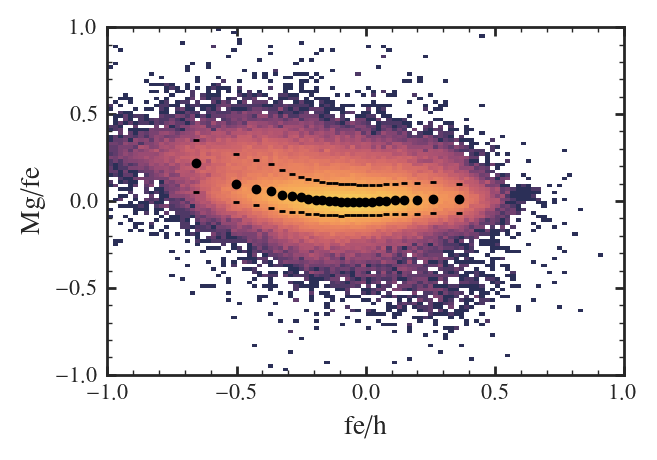

In [20]:
plot_ab(df, "fe_h", "Mg_fe")

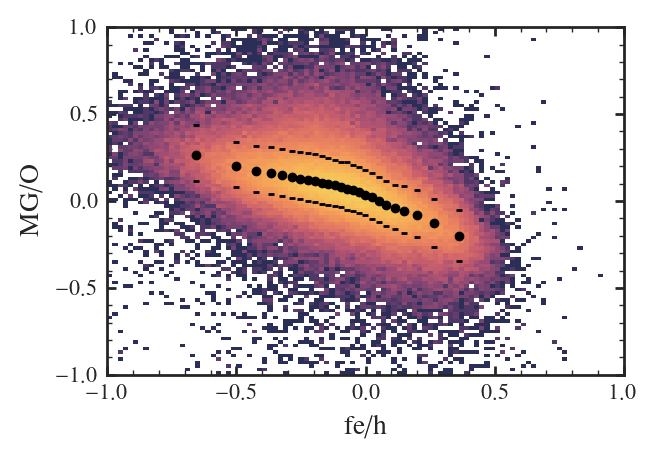

In [21]:
plot_ab(df, "fe_h", "MG_O")

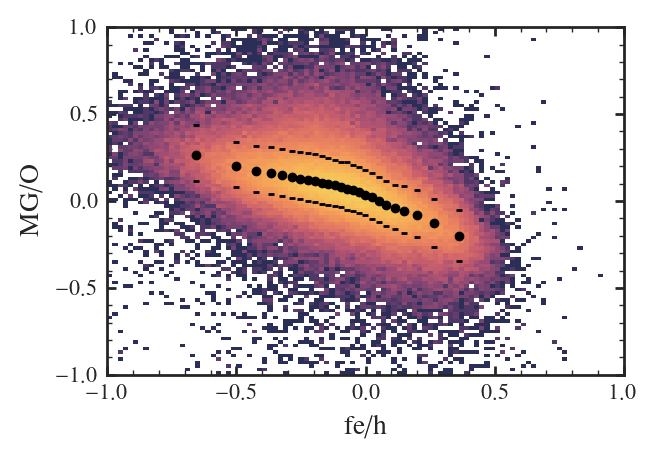

In [22]:
plot_ab(df, "fe_h", "MG_O")

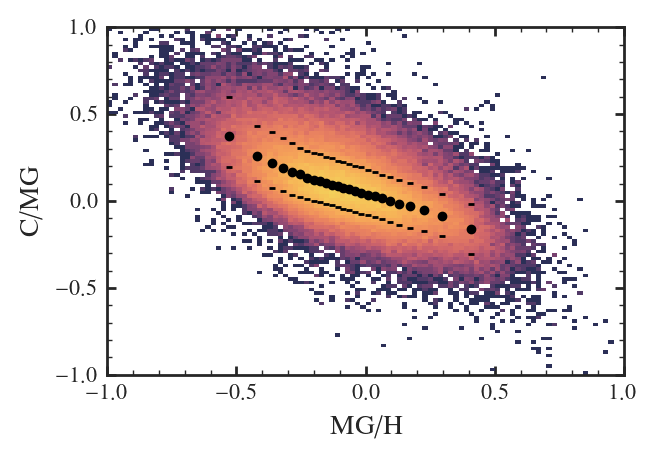

In [23]:
plot_ab(df, "MG_H", "C_MG")

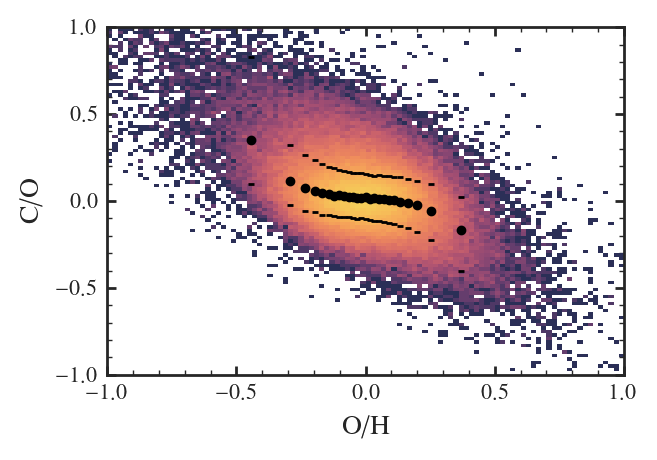

In [24]:
plot_ab(df, "O_H", "C_O")

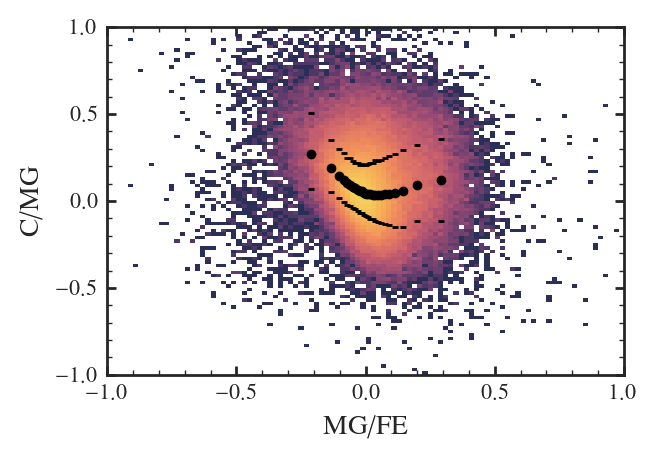

In [25]:
plot_ab(df, "MG_FE", "C_MG")

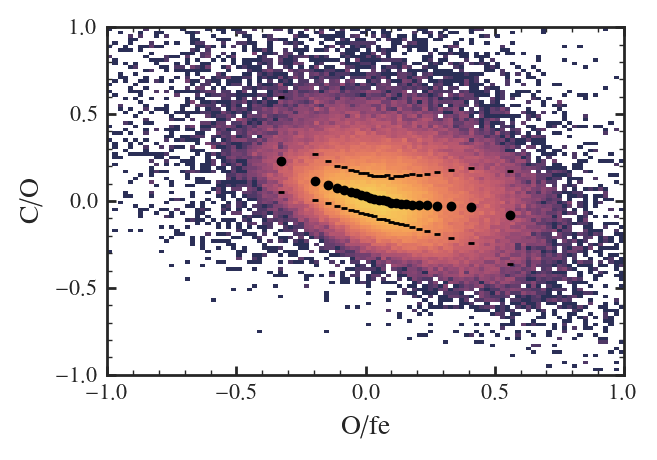

In [26]:
plot_ab(df, "O_fe", "C_O")

In [7]:
df.to_csv("galah_dwarfs.csv")

In [8]:
print(len(df))

205856


# Cleaning GaiaESO
Can find data and docs here https://www.eso.org/sci/publications/announcements/sciann17497.html

In [28]:
gaiaeso_all = Table.read(f"{data_dir}/gaiaeso.fits", format="fits", memmap=True)


In [29]:
sflags = pd.Series(gaiaeso_all["SFLAGS"]).str.decode("utf-8")

quality_mask = ~sflags.str.contains("SNR")
quality_mask &= ~sflags.str.contains("SRP")
quality_mask &= ~sflags.str.contains("BIN")
quality_mask &= ~sflags.str.contains("SSA")
quality_mask &= ~sflags.str.contains("IPA")
quality_mask &= ~sflags.str.contains("PSC")
quality_mask &= ~sflags.str.contains("EML") # emission line


gaiaeso = gaiaeso_all[quality_mask.values].to_pandas()

In [30]:
def combine(*cols):
    tot = 0
    for col in cols:
        tot += np.where(np.isnan(col), 0, 10**col)
        
    return np.log10(tot)
    return np.where(tot <= 0, np.NaN, np.log10(tot / len(cols)))

In [31]:

gso = gaiaeso
logg = gso["LOGG"]
teff = gso["TEFF"]


eps_c = combine(gso["C1"], gso["C2"], gso["C3"], gso["C_C2"])
gso["C_H"] = gcem.eps_to_brak(eps_c, "C")

eps_o = combine(gso["O1"], gso["O2"])
gso["O_H"] = gcem.eps_to_brak(eps_o, "O")

eps_mg = combine(gso["MG1"], gso["MG2"])
gso["MG_H"] = gcem.eps_to_brak(eps_mg, "mg")

gso["FE_H"] = gso.FEH

gso["MG_FE"] = gso.MG_H - gso.FE_H
gso["C_MG"] = gso.C_H - gso.MG_H

gaiaeso = gso

/tmp/slurmtmp.26042669/ipykernel_93433/1584914198.py:6: RuntimeWarning: divide by zero encountered in log10
  return np.log10(tot)
/tmp/slurmtmp.26042669/ipykernel_93433/1584914198.py:6: RuntimeWarning: divide by zero encountered in log10
  return np.log10(tot)
/tmp/slurmtmp.26042669/ipykernel_93433/1584914198.py:6: RuntimeWarning: divide by zero encountered in log10
  return np.log10(tot)


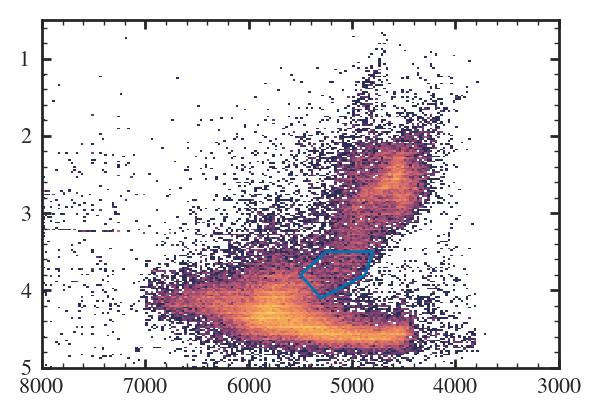

In [32]:
plt.hist2d(gaiaeso["TEFF"], gaiaeso["LOGG"], 200, 
           range=[[3000, 8000], [0.5, 5]], norm=mpl.colors.LogNorm())
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.plot(x, y)

In [33]:
logg = gaiaeso.LOGG
teff = gaiaeso.TEFF

mask = ~np.isnan(logg)
mask &= ~np.isnan(teff)

mask &= logg >= 3.5
# mask &= logg <= 0.004*teff - 15.7
# mask &= logg <= 0.000706*teff + 0.36
# mask &= logg <= -0.0015 * teff + 12.05
# mask &= logg >= 0.0012*teff - 2.8

mask &= gaiaeso["E_LOGG"] < 0.5
mask &= gaiaeso["E_TEFF"] < 200

subgiant_mask = np.copy(mask)
mask = subgiant_mask 

In [34]:
mask_abund = ~np.isnan(gaiaeso["FEH"])

mask_abund &= ~np.all(np.isnan(gaiaeso[["C_C2", "C1", "C2", "C3"]]))
mask_abund &= ~np.all(np.isnan(gaiaeso[["MG1", "MG2", "O1", "O2"]]))

In [35]:
gso = gaiaeso.loc[mask & mask_abund]

(array([2682.,    0.,    0.,    0.,    0.,  420.,    0.,    0.,    0.,
          11.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

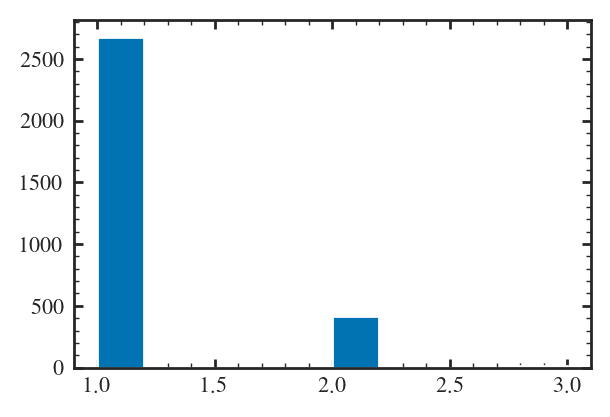

In [36]:
plt.hist(gso["NN_C1"][~pd.isna(gso["NN_C1"])])

Text(0, 0.5, 'C/Mg')

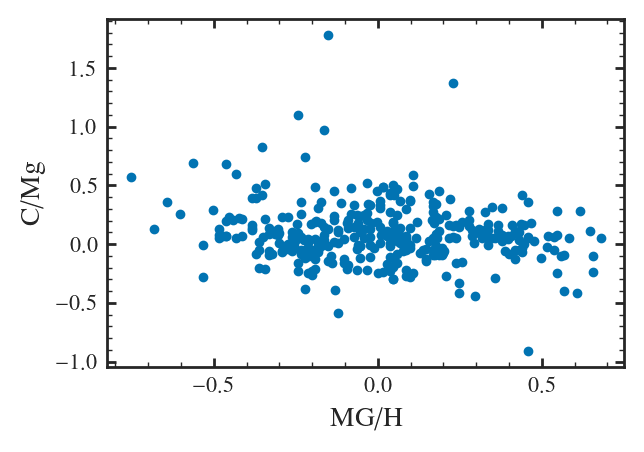

In [37]:
plt.scatter(gso.MG_H, gso.C_MG)
plt.xlabel("MG/H")
plt.ylabel("C/Mg")



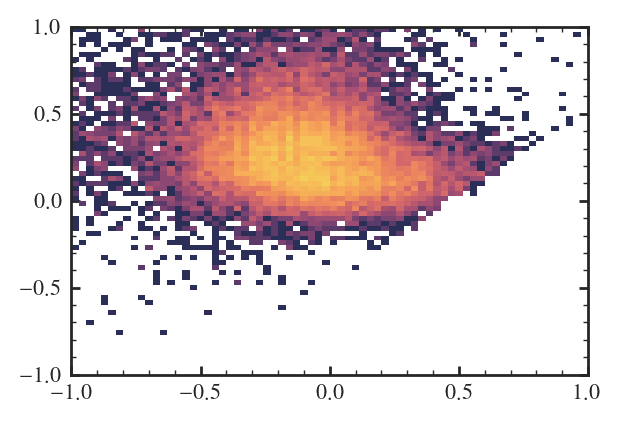

In [38]:
plt.hist2d(gso.MG_H, gso.MG_FE, 70, norm=mpl.colors.LogNorm(), range=[[-1, 1], [-1, 1]]);

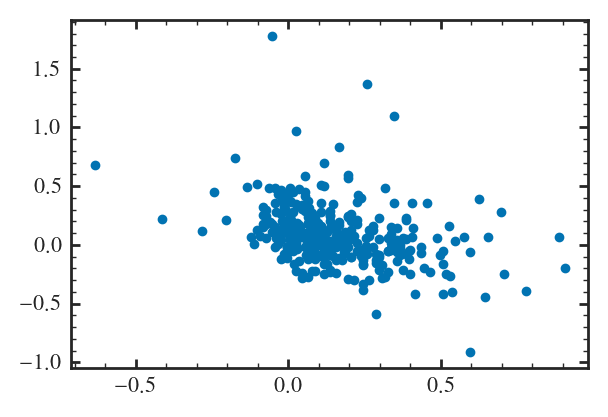

In [39]:
plt.scatter(gso.MG_FE, gso.C_MG)

In [40]:
gso.to_csv("gso_dwarfs.csv")

# CrossMatching Galah

In [148]:
from surp import subgiants
from astropy.coordinates import SkyCoord
from astropy import units as u


# Convert catalogue positions into SkyCoord objects
coords1 = SkyCoord(ra=galah["ra_dr2"] * u.degree, dec=galah["dec_dr2"] * u.degree)
coords2 = SkyCoord(ra=subgiants.RA*u.degree, dec=subgiants.DEC*u.degree)

# Perform crossmatch
idx, d2d, d3d = coords1.match_to_catalog_sky(coords2)

In [149]:
max_sep = 2.0 * u.arcsec
sep_constraint = d2d < max_sep

# Filter matches
matches = idx[sep_constraint]
matched_d2d = d2d[sep_constraint]

In [150]:
idx_l = np.where(sep_constraint)[0] #df indicies
idx_r = matches # apogee indicies

In [151]:
def crossmatch_test(df1, df2, col):
    x1 = np.array(df1[col])
    x2 = np.array(df2[col])
    plt.scatter(x1, x2-x1, s=1, alpha=0.5)
    plt.axhline(0, c="k")
    plt.ylabel("col".replace("_", "/"))

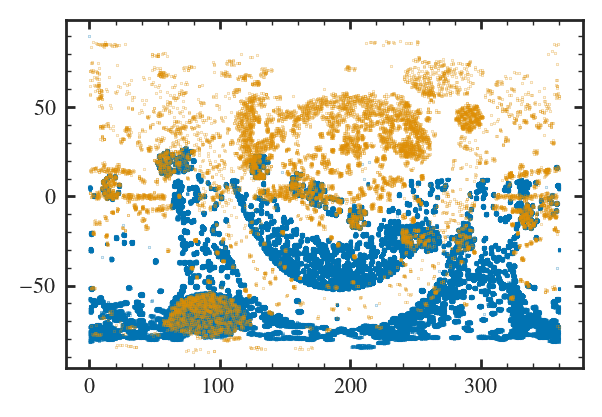

In [152]:
plt.scatter(galah.ra_dr2, galah.dec_dr2,  s=0.01, alpha=1)
plt.scatter(subgiants.RA,subgiants.DEC,  s=0.01, alpha=1)

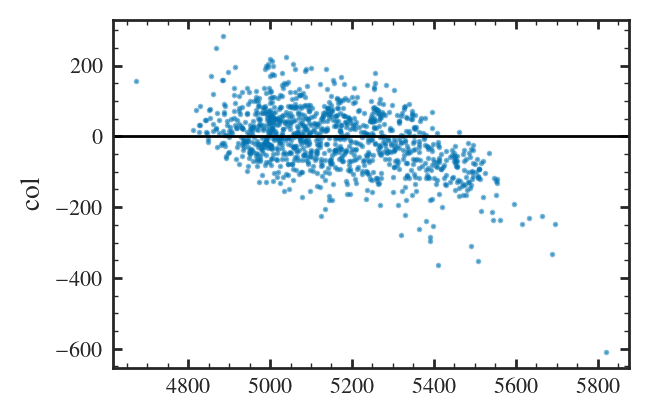

In [153]:
crossmatch_test(galah.iloc[idx_l], subgiants.iloc[idx_r], "TEFF")

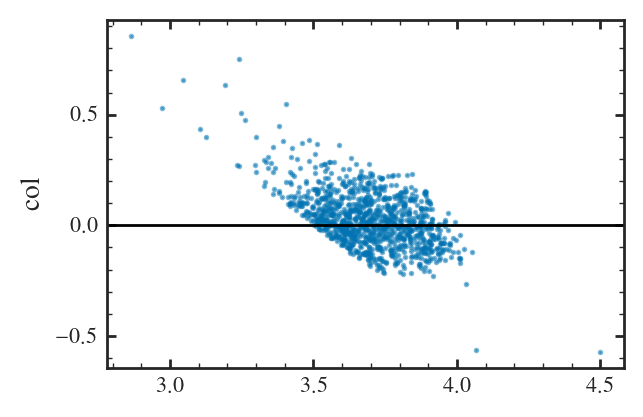

In [154]:
crossmatch_test(galah.iloc[idx_l], subgiants.iloc[idx_r], "LOGG")

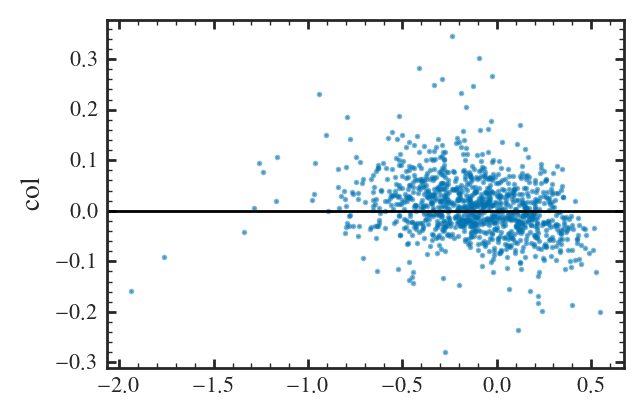

In [155]:
crossmatch_test(galah.iloc[idx_l], subgiants.iloc[idx_r], "FE_H")

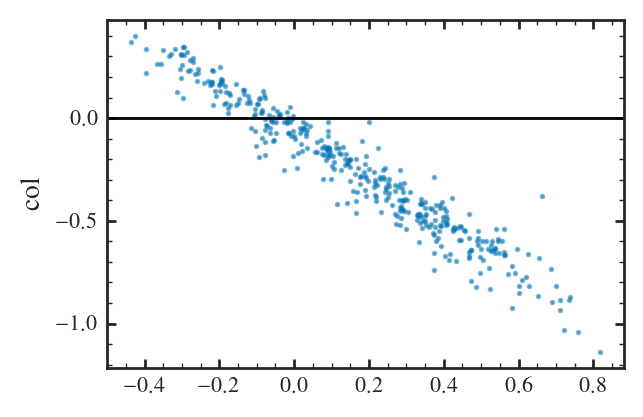

In [156]:
crossmatch_test(galah.iloc[idx_l], subgiants.iloc[idx_r], "C_MG")

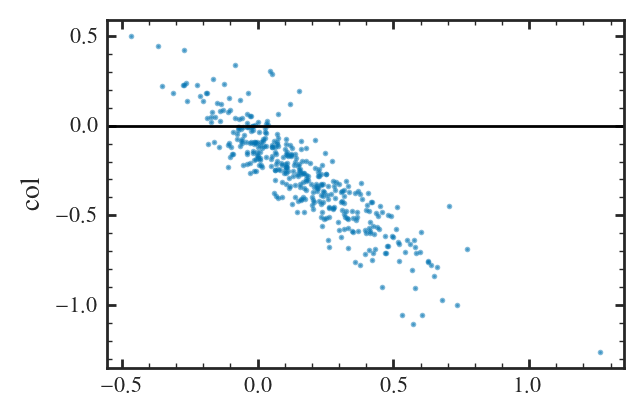

In [157]:
crossmatch_test(galah.iloc[idx_l], subgiants.iloc[idx_r], "C_O")

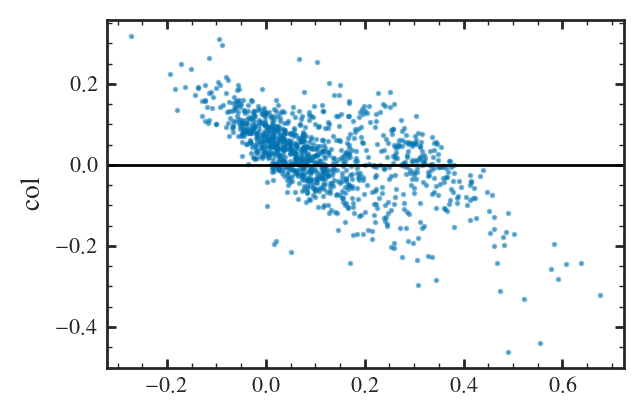

In [158]:
crossmatch_test(galah.iloc[idx_l], subgiants.iloc[idx_r], "MG_FE")

# Crossmatch GaiaESO

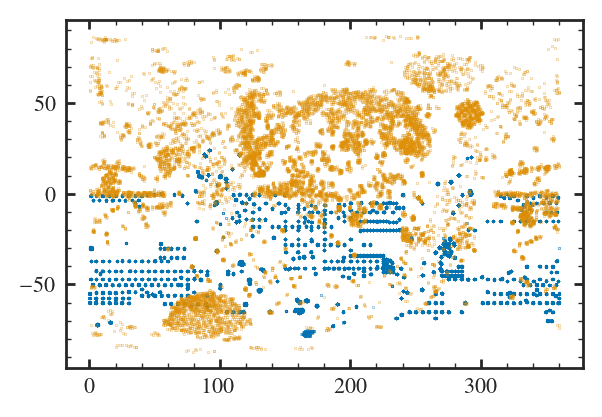

In [116]:
plt.scatter(gaiaeso.RA, gaiaeso.DECLINATION,  s=0.01, alpha=1)
plt.scatter(subgiants.RA,subgiants.DEC,  s=0.01, alpha=1)

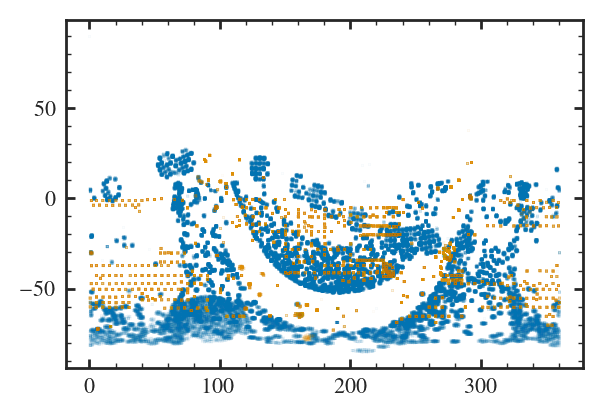

In [114]:
plt.scatter(galah.ra_dr2,galah.dec_dr2,  s=0.01, alpha=0.1)
plt.scatter(gaiaeso.RA, gaiaeso.DECLINATION,  s=0.01, alpha=0.1)


In [60]:
# Convert catalogue positions into SkyCoord objects
coords1 = SkyCoord(ra=gaiaeso["RA"] * u.degree, dec=gaiaeso["DECLINATION"] * u.degree)
coords2 = SkyCoord(ra=galah.ra_dr2*u.degree, dec=galah.dec_dr2*u.degree)

# Perform crossmatch
idx, d2d, d3d = coords1.match_to_catalog_sky(coords2)

max_sep = 1.0 * u.arcsec
sep_constraint = d2d < max_sep

# Filter matches
matches = idx[sep_constraint]
matched_d2d = d2d[sep_constraint]

idx_l = np.where(sep_constraint)[0] #df indicies
idx_r = matches # apogee indicies

In [139]:
def crossmatch_test(df1, df2, col):
    x1 = np.array(df1[col])
    x2 = np.array(df2[col])
    plt.scatter(x1, x2-x1, fc="None", ec=arya.style.COLORS[0], alpha=0.5)
    plt.axhline(0, c="k")
    plt.ylabel("col".replace("_", "/"))

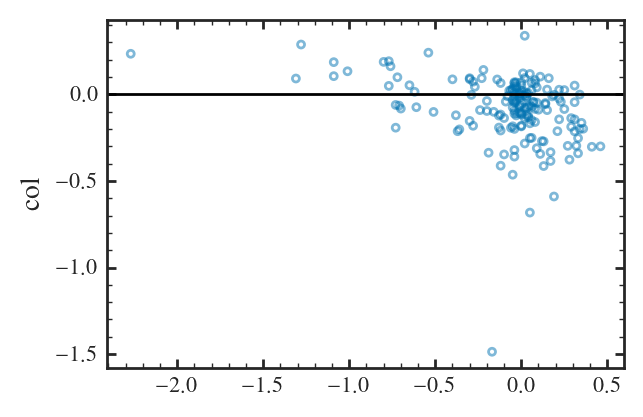

In [140]:
crossmatch_test(gaiaeso.iloc[idx_l], galah.iloc[idx_r], "FE_H")

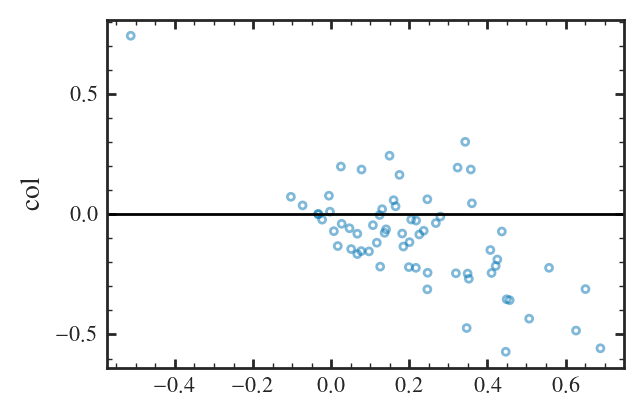

In [141]:
crossmatch_test(gaiaeso.iloc[idx_l], galah.iloc[idx_r], "MG_FE")

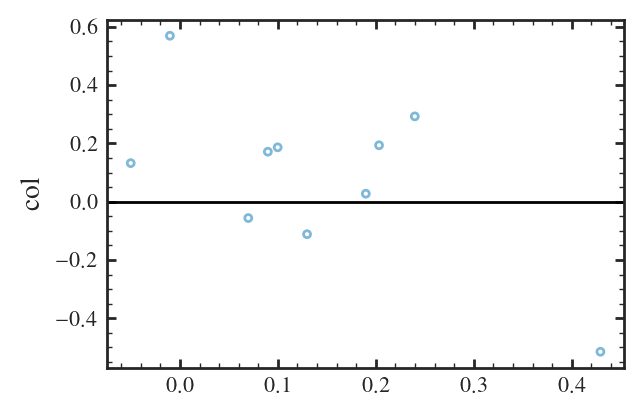

In [142]:
crossmatch_test(gaiaeso.iloc[idx_l], galah.iloc[idx_r], "C_MG")

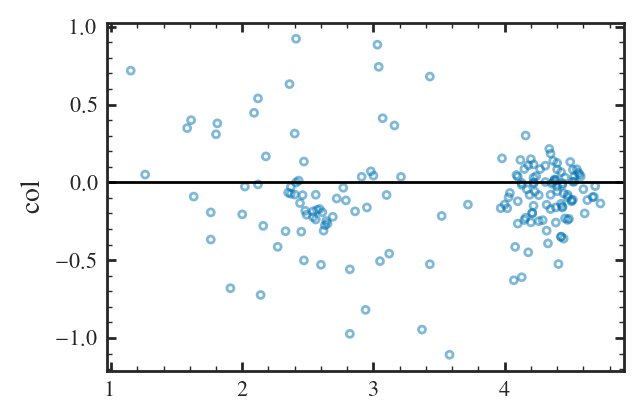

In [143]:
crossmatch_test(gaiaeso.iloc[idx_l], galah.iloc[idx_r], "LOGG")

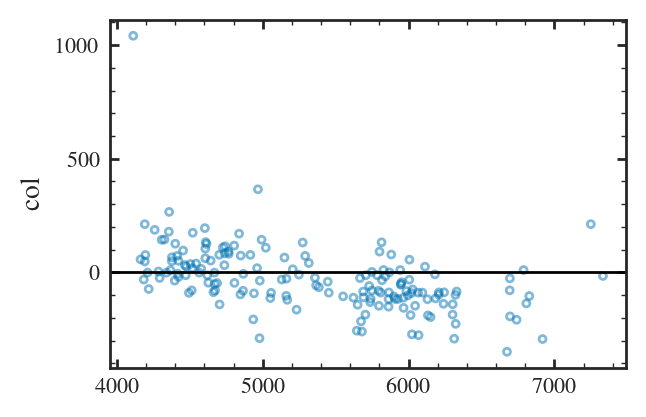

In [144]:
crossmatch_test(gaiaeso.iloc[idx_l], galah.iloc[idx_r], "TEFF")